# ARIMA Forecasting

## Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)

from datetime import date
from dateutil.relativedelta import relativedelta

from keras import optimizers
from keras import Sequential
from keras.layers import LSTM, Dropout
from tensorflow.keras import layers
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import TimeDistributed

Using TensorFlow backend.


## Reading Data from Snowflake

In [2]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

USER = "PC_USER"
PASSWORD = "Edge@123"
ACCOUNT = "edgematics.eu-west-1"
WAREHOUSE = "TAL_SF_WH"
DATABASE = "TAL_SF"
SCHEMA = "PUBLIC"

urll = f'snowflake://{USER}:{PASSWORD}@{ACCOUNT}/{DATABASE}/{SCHEMA}?warehouse={WAREHOUSE}'
engine = create_engine(urll)

# engine = create_engine(
#     URL(account=ACCOUNT,
#         user=USER,
#         password=PASSWORD,
#         warehouse=WAREHOUSE,
#         database=DATABASE,
#         schema=SCHEMA))

table_name = "customer_acquisition"

sql = f"SELECT * FROM {DATABASE}.{SCHEMA}.{table_name}"
with engine.connect() as conn:
    df = pd.read_sql_query(sql, con=conn)
print(df.head())
df.info()
df.to_csv('customer_acquisition.csv')

  activation_date  circle_id    emirate_name            subs_key      msisdn  \
0      2014-11-03          4        Fujairah  050260011120141103  0502600111   
1      2014-11-03          1       Abu Dhabi  056984621520141103  0569846215   
2      2014-11-03          6         Sharjah  056821731120141103  0568217311   
3      2014-11-03          5  Ras Al Khaimah  050322789520141103  0503227895   
4      2014-11-03          3           Dubai  050728068020141103  0507280680   

  acquisition_region      acquisition_pos  pre_post_ind customer_type  \
0           Fujairah        Galleria Mall             2    Enterprise   
1          Abu Dhabi       Abu Dhabi Mall             1    Enterprise   
2            Sharjah        Sahara Centre             1    Enterprise   
3     Ras Al Khaimah           Manar Mall             1        Retail   
4              Dubai  Dubai Festival City             1        Retail   

  acquisition_sales_channel_key  ... disconnection_date  \
0                    

In [3]:
# df['day']=pd.DatetimeIndex(df['activation_date']).date
df['year'] = pd.DatetimeIndex(df['activation_date']).year
df['month'] = pd.DatetimeIndex(df['activation_date']).month
df['year'] = pd.DatetimeIndex(df['activation_date']).year
df['ad'] = pd.to_datetime(df['activation_date']).dt.to_period('M')
df.ad = df.ad.values.astype('datetime64[ns]')

migrtype = pd.get_dummies(df['migration_type'], prefix='migrtype')
migrtype['month'] = df['month']
migrtype['year'] = df['year']
migrtype = pd.concat([migrtype, df['ad']], axis=1)

attr = migrtype.columns[0]
group = migrtype.groupby(['ad'], as_index=False)[attr].sum()
group.index = group.ad

y = group[attr]
X = group['ad']

n = len(y)
length = 6
length1 = int(n / length)

samples = []
xx = []

xx = np.arange(length * length1).reshape(-1, length, 1)
data = np.array(y).reshape(-1, length, 1)

X_train, X_test, y_train, y_test = train_test_split(xx,
                                                    data,
                                                    shuffle=False,
                                                    test_size=0.1)

nm = 1
mpredict = nm * length
ar = np.arange(len(X), len(X) + mpredict).reshape(nm, mpredict, 1)
X_test = np.vstack((X_test, ar))
X_test.shape

startdate = X[0]

six_months = startdate + relativedelta(months=len(X_train.flatten()) +
                                       len(X_test.flatten()) - 1)
enddate = six_months.strftime("%m-%Y")
startdate = startdate.strftime("%m-%Y")

X_labels = pd.date_range(startdate, enddate,
                         freq='MS').strftime("%Y-%b").tolist()
X_labels = [str(x) for x in X_labels]
X_tr_labels = X_labels[:len(X_train.flatten())]
X_test_labels = X_labels[len(X_train.flatten()):]

## Forecasting

In [4]:
model = Sequential()
model.add(
    LSTM(128,
         activation='tanh',
         input_shape=(length, 1),
         return_sequences=True))
# model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=12, activation='relu'))
model.add(Dense(units=6, activation='relu'))
# model.add(Dense(units=3, activation='relu'))
model.add(Dense(units=1, activation='linear'))
adam = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse')
# model.fit(X_train, y_train, epochs=1000)
# model.save_weights(attr+'model.h5')
# model.load_weights(attr+'model.h5')
# model.save(attr+"model")

# model_yaml = model.to_yaml()
# with open(attr + "model.yaml", "w") as yaml_file:
#     yaml_file.write(model_yaml)
# # serialize weights to HDF5
# model.save_weights(attr + "model.h5")
# print("Saved model to disk")

# later...
from keras.models import model_from_yaml
# load YAML and create model
yaml_file = open(attr + 'model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights(attr + "model.h5")
print("Loaded model from disk")

Loaded model from disk


In [5]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test = y_test.flatten()
y_train = y_train.flatten()
X_test = X_test.flatten()

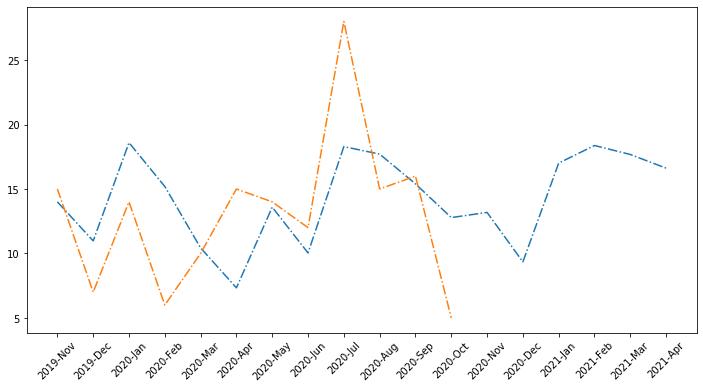

In [6]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(len(X_test_labels)))
ax.set_xticklabels(X_test_labels, rotation=45)

plt.plot(y_pred, '-.')
plt.plot(y_test, '-.')

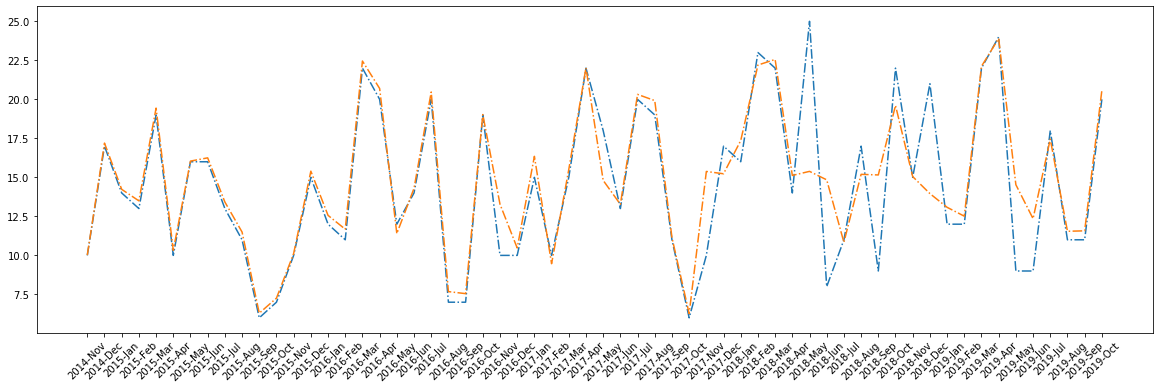

In [7]:
y_tr_pred = model.predict(X_train)
y_tr_pred = y_tr_pred.flatten()

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
ax.set_xticks(np.arange(len(X_tr_labels)))
ax.set_xticklabels(X_tr_labels, rotation=45)

plt.plot(y_train, '-.')
plt.plot(y_tr_pred, '-.')